# 1. Implementing the GCN Layer

In [ ]:
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

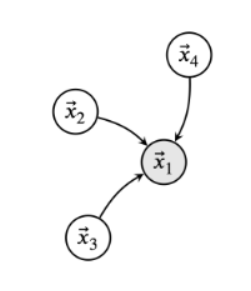

In [77]:
# 定义Data实例的属性数据
edge_index = torch.tensor([[1, 2, 3], [0, 0, 0]], dtype=torch.long)
x = torch.tensor([[1], [1], [1], [1]], dtype=torch.float)

x has shape [N, in_channels], N表示节点个数    
edge_index has shape [2, E], E表示边的个数

In [90]:
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        print("\nAdd self-loops edge_index--------------")
        print(edge_index)

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)
        print("\nLinearly transform--------------")
        print(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        print("\nrow-------",row)
        print("\ncol-------",col)
        deg = degree(col, x.size(0), dtype=x.dtype)
        print("\ndegree------------------")
        print(deg)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        print("\nnorm--------------")
        print(norm)

        # Step 4-5: Start propagating messages.
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]
        
        print("\nx_j--------------")
        print(x_j)
        print("\nnorm.view(-1, 1) * x_j--------------")
        print(norm.view(-1, 1) * x_j)

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

In [91]:
conv = GCNConv(1, 2)
ret = conv(x, edge_index)
ret


Add self-loops edge_index--------------
tensor([[1, 2, 3, 0, 1, 2, 3],
        [0, 0, 0, 0, 1, 2, 3]])

Linearly transform--------------
tensor([[ 0.8011, -0.1327],
        [ 0.8011, -0.1327],
        [ 0.8011, -0.1327],
        [ 0.8011, -0.1327]], grad_fn=<AddmmBackward>)

row------- tensor([1, 2, 3, 0, 1, 2, 3])

col------- tensor([0, 0, 0, 0, 1, 2, 3])

degree------------------
tensor([4., 1., 1., 1.])

norm--------------
tensor([0.5000, 0.5000, 0.5000, 0.2500, 1.0000, 1.0000, 1.0000])

x_j--------------
tensor([[ 0.8011, -0.1327],
        [ 0.8011, -0.1327],
        [ 0.8011, -0.1327],
        [ 0.8011, -0.1327],
        [ 0.8011, -0.1327],
        [ 0.8011, -0.1327],
        [ 0.8011, -0.1327]], grad_fn=<IndexSelectBackward>)

norm.view(-1, 1) * x_j--------------
tensor([[ 0.4005, -0.0664],
        [ 0.4005, -0.0664],
        [ 0.4005, -0.0664],
        [ 0.2003, -0.0332],
        [ 0.8011, -0.1327],
        [ 0.8011, -0.1327],
        [ 0.8011, -0.1327]], grad_fn=<MulBackward0>

tensor([[ 1.4019, -0.2322],
        [ 0.8011, -0.1327],
        [ 0.8011, -0.1327],
        [ 0.8011, -0.1327]], grad_fn=<ScatterAddBackward>)

# 2. GCN的简单实例

In [92]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [93]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='./data/Cora', name='Cora')

In [94]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [95]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.7980
